# Step-1: Loading the Dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import glob 
filePaths = glob.glob("/home/prakhar/Desktop/College/3rdYear/SEM-VI/MinorProject/Datasets/archive-2/*.csv")
df_list = [pd.read_csv(file,low_memory=False) for file in filePaths]
df=pd.concat(df_list,ignore_index=True)
print(df.shape)
print(df.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

In [4]:
df.columns = df.columns.str.strip()
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

# Step-2: Pre-Processing

In [5]:
df.dtypes #Viewing Datatype

Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
Idle Std                       float64
Idle Max                         int64
Idle Min                         int64
Label                           object
Length: 79, dtype: object

In [6]:
is_inf = df.isin([np.inf, -np.inf])

inf_counts = is_inf.sum()

# Filter to show only columns with infinite values
columns_with_inf = inf_counts[inf_counts > 0]
print("Columns with infinite values:\n", columns_with_inf)

nan_counts = df.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print("\nColumns with NaN values:\n", columns_with_nan)

combined_counts = nan_counts + inf_counts

# Filter to show only columns with any NaN or inf values
columns_with_nan_or_inf = combined_counts[combined_counts > 0]
print("\nColumns with NaN or infinite values:\n", columns_with_nan_or_inf)

duplicate_rows_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows_count)

Columns with infinite values:
 Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64

Columns with NaN values:
 Flow Bytes/s    1358
dtype: int64

Columns with NaN or infinite values:
 Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64

Number of duplicate rows: 308381


In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True) #Replacing inf values
df.dropna(inplace=True) #Replacing NaN values
df.drop_duplicates(inplace=True) #Removing duplicates to improve accuracy
category_mapping = {
    'BENIGN': 'BENIGN',
    'Bot': 'BOTNET',
    'DDoS': 'DOS',
    'DoS GoldenEye': 'DOS',
    'DoS Hulk': 'DOS',
    'DoS Slowhttptest': 'DOS',
    'DoS slowloris': 'DOS',
    'FTP-Patator': 'BRUTE_FORCE',
    'SSH-Patator': 'BRUTE_FORCE',
    'Heartbleed': 'WEB_ATTACK',
    'Infiltration': 'WEB_ATTACK',
    'PortScan': 'RECONNAISSANCE',
    'Web Attack � Brute Force': 'WEB_ATTACK',
    'Web Attack � Sql Injection': 'WEB_ATTACK',
    'Web Attack � XSS': 'WEB_ATTACK'
}
#Applying Mapping to simplify labels
df['Label'] =df['Label'].map(category_mapping)

In [8]:
print(df['Label'].value_counts())  # Before encoding

Label
BENIGN            2095057
DOS                321759
RECONNAISSANCE      90694
BRUTE_FORCE          9150
WEB_ATTACK           2190
BOTNET               1948
Name: count, dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder #After Encoding
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [10]:
print(df['Label'].value_counts())  # Before encoding

Label
0    2095057
3     321759
4      90694
2       9150
5       2190
1       1948
Name: count, dtype: int64


In [11]:
import pandas as pd

# Get class counts
class_counts = df['Label'].value_counts()

# Select classes with more than 5000 samples
selected_classes = class_counts[class_counts > 50000].index.tolist()

# Manually include "WEB_ATTACK" and "BOTNET" if they exist in the dataset
for attack in [1, 5, 2]:
    if attack in df['Label'].values and attack not in selected_classes:
        selected_classes.append(attack)

# Select rows where 'Label' is in selected_classes
selected = df[df['Label'].isin(selected_classes)]

dfs = []
for name in selected_classes:
    df_class = selected[selected['Label'] == name]

    # Downsample if the class has more than 5000 samples
    if len(df_class) > 50000:
        df_class = df_class.sample(n=50000, random_state=0)

    dfs.append(df_class)

# Combine all sampled data
balanced_df = pd.concat(dfs, ignore_index=True)

# Check final class distribution
print(balanced_df['Label'].value_counts())

Label
0    50000
3    50000
4    50000
2     9150
5     2190
1     1948
Name: count, dtype: int64


In [12]:
balanced_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,62874,4,2,116,186,29,29,29.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,0
1,57225,86,1,1,0,0,0,0,0.000,0.000000,...,32,0.00000,0.00000,0,0,0.000,0.00000,0,0,0
2,80,116003861,16,14,440,412,356,0,27.500,87.612784,...,20,46441.09091,31255.09835,140678,36852,9995557.727,14892.00092,10000000,9950679,0
3,443,5683083,8,6,397,3716,216,0,49.625,79.224703,...,20,269399.00000,0.00000,269399,269399,5413681.000,0.00000,5413681,5413681,0
4,53,23652,1,1,48,128,48,48,48.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,0


In [13]:
from imblearn.over_sampling import SMOTE

x = balanced_df.drop('Label', axis=1)
y = balanced_df['Label']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(x, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Label'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

print(blnc_data['Label'].value_counts())
blnc_data.head()

Label
4    50000
0    50000
3    50000
1    50000
5    50000
2    50000
Name: count, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
118100,6669,40,1,1,2,6,2,2,2.000000,0.000000,...,24,0.000,0.000,0,0,0.0,0.000000,0,0,4
22484,53,23821,2,2,90,212,45,45,45.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000000,0,0,0
11879,80,50401,5,3,1059,124,1059,0,211.800000,473.599198,...,32,0.000,0.000,0,0,0.0,0.000000,0,0,0
81786,80,509,3,0,0,0,0,0,0.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000000,0,0,3
1978,80,93596351,22,23,1220,15317,343,0,55.454545,120.867786,...,32,910577.875,2510496.614,7123740,22866,10000000.0,2446.087839,10000000,10000000,0


In [14]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
x = blnc_data.drop('Label',axis=1)
y = blnc_data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
n_components = 20
ipca = IncrementalPCA(n_components=n_components, batch_size=500)
x_pca = ipca.fit_transform(X_scaled) 
print(f"Explained Variance Ratio: {sum(ipca.explained_variance_ratio_):.4f}")
x = x_pca

Explained Variance Ratio: 0.9335


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,shuffle=True)

# Step-3: Applying Classifier Algorithms

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
import tensorflow as tf
import keras
from keras import layers,regularizers,optimizers,callbacks

2025-04-14 22:48:08.349760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744651088.448865   32090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744651088.472842   32090 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744651088.690962   32090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744651088.690991   32090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744651088.690996   32090 computation_placer.cc:177] computation placer alr

#### Step-3.1: Applying Random Foressts

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Importing Random Forest classifier
rf = RandomForestClassifier(n_estimators=100,max_depth=20,random_state=42)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test) #Performing Random Forest

In [20]:
print(classification_report(y_test, y_pred,digits=4)) #Printing Classification Report
class_indices = rf.classes_
print(class_indices)

              precision    recall  f1-score   support

           0     0.9151    0.9063    0.9107     12534
           1     0.9596    0.9774    0.9684     12503
           2     0.9895    0.9760    0.9827     12502
           3     0.9646    0.9763    0.9704     12480
           4     0.9834    0.9917    0.9876     12560
           5     0.9742    0.9587    0.9664     12421

    accuracy                         0.9644     75000
   macro avg     0.9644    0.9644    0.9643     75000
weighted avg     0.9644    0.9644    0.9643     75000

[0 1 2 3 4 5]


In [21]:
cv_rf = cross_val_score(rf, x_train, y_train, cv=5)
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf)))
print(f'\nMean cross-validation score: {cv_rf.mean():.2f}')


Cross-validation scores: 0.9534, 0.9465777777777777, 0.957, 0.9564888888888889, 0.9540666666666666

Mean cross-validation score: 0.95


In [26]:
print(rf.score(x_train,y_train)) #RF Score x_train,y_train

0.9657822222222222


In [27]:
print(rf.score(x_test, y_test)) #RF Score x_test,y_test

0.9643866666666666


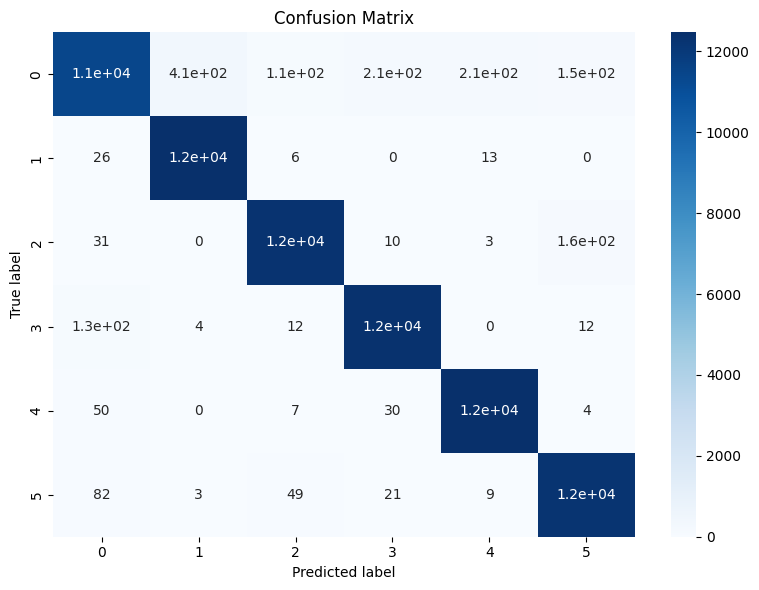

In [28]:
# Compute ROC curve
# False Positive Rate, True Positive Rate
conf_mtr = confusion_matrix(y_true=y_test,y_pred=y_pred)
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

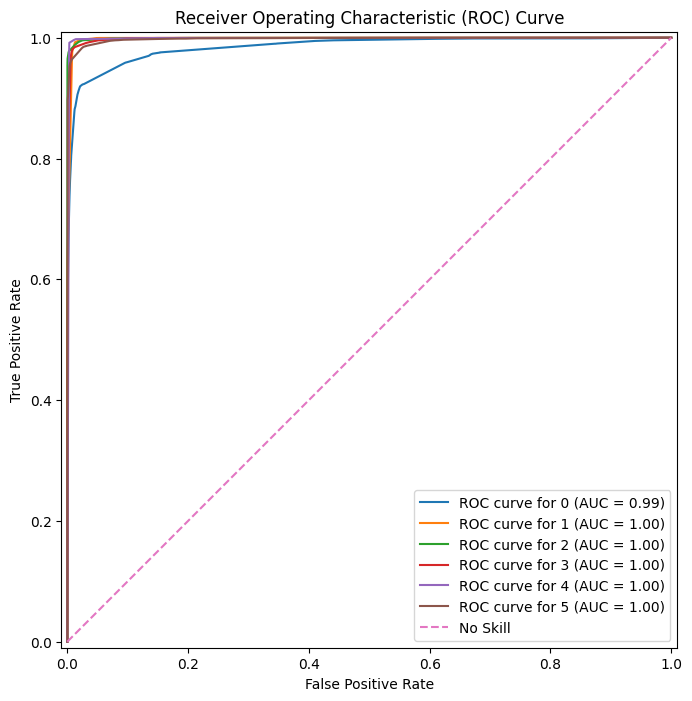

In [29]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    y_score = rf.predict_proba(x_test)[:, i]
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score,
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Step-3.2: Applying KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier #Importing KNN
knn = KNeighborsClassifier(n_neighbors= 100) #Changing Value Manually (Due to Performance Reasons)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)  # Performing Random Forest

In [23]:
print(classification_report(y_test, y_pred, digits=4)) #Printing Classification Report

              precision    recall  f1-score   support

           0     0.9730    0.9129    0.9420     12534
           1     0.9675    0.9964    0.9818     12503
           2     0.9854    0.9837    0.9845     12502
           3     0.9786    0.9875    0.9830     12480
           4     0.9813    0.9928    0.9870     12560
           5     0.9739    0.9868    0.9803     12421

    accuracy                         0.9766     75000
   macro avg     0.9766    0.9767    0.9764     75000
weighted avg     0.9766    0.9766    0.9764     75000



In [24]:
cv_knn = cross_val_score(knn, x_train, y_train, cv=5)
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn)))
print(f'\nMean cross-validation score: {cv_knn.mean():.2f}')


Cross-validation scores: 0.9769111111111111, 0.9747555555555556, 0.9756888888888889, 0.9755777777777778, 0.9754888888888888

Mean cross-validation score: 0.98


In [30]:
print(knn.score(x_train, y_train)) #RF Score x_train,y_train

0.9775777777777778


In [31]:
print(knn.score(x_test, y_test)) #RF Score x_train,y_train

0.97664


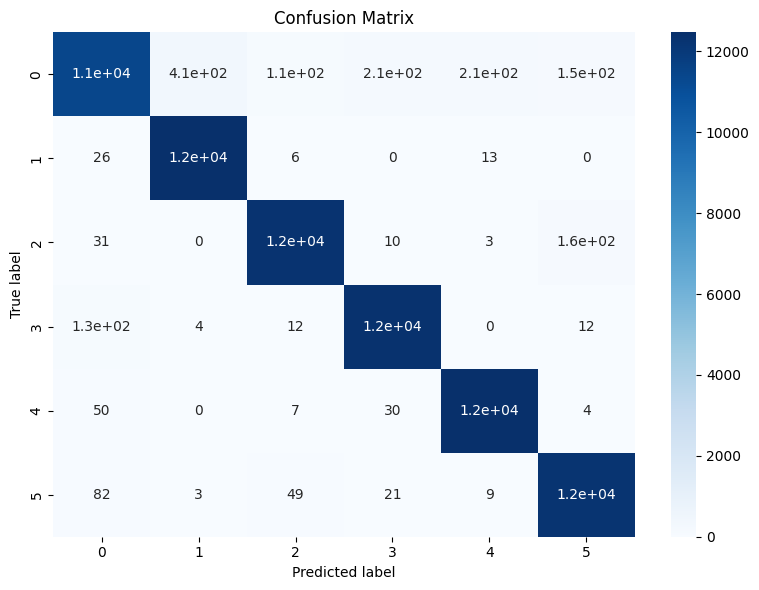

In [32]:
# Compute Confusion Matrix
# False Positive Rate, True Positive Rate
conf_mtr = confusion_matrix(y_true=y_test, y_pred=y_pred)
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

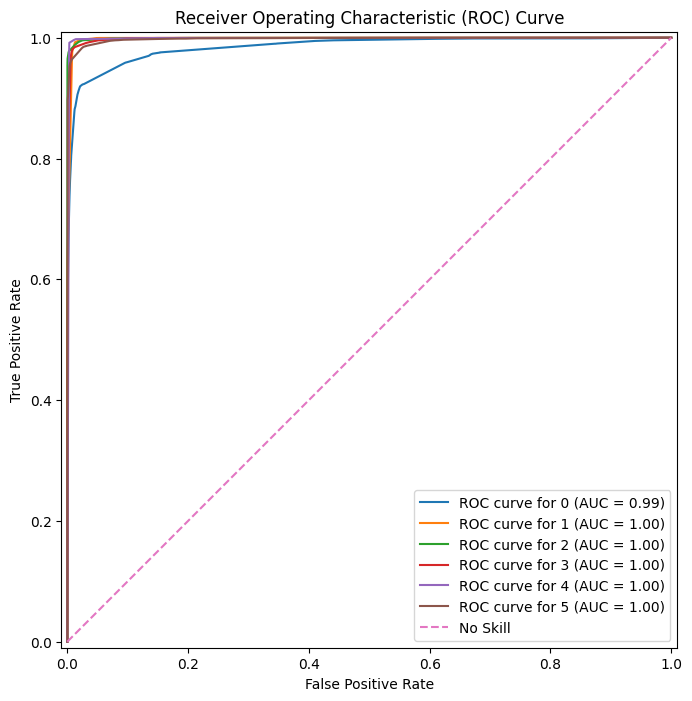

In [33]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    y_score = rf.predict_proba(x_test)[:, i]
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score,
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Step-3.3: Applying DNN

In [22]:
model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1],)))  # Input layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(256, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(6, activation='softmax'))  # Output layer

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,382 (271.02 KB)

 Trainable params: 69,382 (271.02 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/dnn_best.keras", save_best_only=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
              'accuracy'])  # compiling model

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, callbacks=[
          early_stopping, model_checkpoint],validation_data=(x_test,y_test))  # Fitting Model
model.save("Models/Final/DNN.h5")  # Saving the model

Epoch 1/50


E0000 00:00:1744629569.574786   28209 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1744629569.780288   28209 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-04-14 16:49:29.792994: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at xla_ops.cc:591 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_27882/1514012457.py", line 1, in <module>

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_6806]

In [20]:
print(f"Result of Prediction") #Performing Predictions
predictions=model.predict(x=x_test)
print(predictions)
print("predictions shape:", predictions.shape)

Result of Prediction
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 785us/step
[[5.1413081e-03 5.5685832e-13 4.9669165e-05 2.3800954e-05 7.4183496e-05
  9.9471104e-01]
 [4.5988138e-05 4.0788839e-12 9.9995345e-01 1.0171353e-07 6.8175371e-10
  2.9967401e-07]
 [4.1050182e-08 1.7589648e-12 9.9999994e-01 8.9094347e-15 2.0713429e-11
  1.7870275e-10]
 ...
 [2.4306098e-02 9.7478265e-01 6.3705392e-04 1.2872506e-04 4.6925790e-05
  9.8525583e-05]
 [3.0642433e-02 9.6935678e-01 3.6603009e-07 3.5793414e-07 6.8491410e-08
  1.6389685e-09]
 [3.9377706e-08 9.8089004e-31 2.7859466e-11 9.9999994e-01 4.5187054e-09
  6.1621246e-20]]
predictions shape: (75000, 6)


#### Step-3.4: Applying DCNN

In [37]:
x_train_reshaped = x_train.reshape(
    x_train.shape[0], x_train.shape[1], 1)

x_test_reshaped = x_test.reshape(
    x_test.shape[0], x_test.shape[1], 1)

In [ ]:
# Create the model as before
model_cnn = keras.Sequential()

model_cnn.add(layers.Input(shape=(x_train_reshaped.shape[1], 1)))
model_cnn.add(layers.Conv1D(128, 20, data_format='channels_last',
                            activation='relu', padding='same'))
model_cnn.add(layers.Conv1D(256, 20, data_format='channels_last',
                            activation='relu', padding='same'))

model_cnn.add(layers.Flatten())

model_cnn.add(layers.Dense(256, activation='relu',
                           kernel_regularizer=keras.regularizers.l1_l2()))

model_cnn.add(layers.Dense(6, activation='softmax'))

W0000 00:00:1743051326.022475   10165 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 128)        │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,310,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,822 (7.52 MB)

 Trainable params: 1,970,822 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
callback = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/cnn_best.keras", save_best_only=True)
model_cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
                  'accuracy'])  # compiling model

In [24]:
history = model_cnn.fit(x_train_reshaped, y_train, epochs=50, batch_size=32, callbacks=[
              early_stopping, model_checkpoint], validation_data=(x_test_reshaped, y_test))  # Fitting Model
model_cnn.save("Models/Final/CNN.h5")  # Saving the model

Epoch 1/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 193s 27ms/step - accuracy: 0.9325 - loss: 0.2574 - val_accuracy: 0.9743 - val_loss: 0.0879
Epoch 2/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 186s 26ms/step - accuracy: 0.9738 - loss: 0.0875 - val_accuracy: 0.9779 - val_loss: 0.0728
Epoch 3/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 182s 26ms/step - accuracy: 0.9768 - loss: 0.0754 - val_accuracy: 0.9794 - val_loss: 0.0646
Epoch 4/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 182s 26ms/step - accuracy: 0.9789 - loss: 0.0685 - val_accuracy: 0.9792 - val_loss: 0.0628
Epoch 5/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 182s 26ms/step - accuracy: 0.9804 - loss: 0.0627 - val_accuracy: 0.9813 - val_loss: 0.0630
Epoch 6/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 181s 26ms/step - accuracy: 0.9809 - loss: 0.0620 - val_accuracy: 0.9825 - val_loss: 0.0584
Epoch 7/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 188s 27ms/step - accuracy: 0.9823 - loss: 0.0574 - val_accuracy: 0.9819 - val_loss: 0.0563
Epoch 8/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 191s 27ms/step - accuracy: 

In [25]:
print(f"Result of Prediction")  # Performing Predictions
predictions = model_cnn.predict(x=x_test_reshaped)
print(predictions)
print("predictions shape:", predictions.shape)

Result of Prediction
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
[[4.19297162e-03 3.36985018e-09 5.80093656e-05 4.91282553e-05
  2.64665752e-04 9.95435238e-01]
 [9.48653673e-04 3.60830615e-14 9.99051154e-01 1.16293222e-07
  1.02613136e-07 5.52617196e-09]
 [2.90783646e-06 1.38562962e-13 9.99997079e-01 2.71710932e-10
  4.50527150e-11 7.59171281e-10]
 ...
 [2.12407820e-02 9.78705466e-01 5.27356769e-06 2.54320512e-05
  4.12782674e-06 1.90565206e-05]
 [7.71389110e-03 9.92285788e-01 1.59661673e-09 2.73120946e-07
  6.74596521e-08 3.53578056e-10]
 [4.34548439e-11 0.00000000e+00 1.82297420e-34 9.99999940e-01
  2.23466255e-19 0.00000000e+00]]
predictions shape: (75000, 6)


In [26]:
print(f"Results of Testing")  # Testing the model
model_cnn.evaluate(x_test_reshaped, y_test)

Results of Testing
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9878 - loss: 0.0394


[0.04063998907804489, 0.9874133467674255]

In [17]:
model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1],)))  # Input layer

model.add(layers.Dense(1024, activation='relu'))  # Hidden layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01))  # Dropout layer

model.add(layers.Dense(768, activation='relu'))  # Hidden layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01))  # Dropout layer

model.add(layers.Dense(512, activation='relu'))  # Hidden layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01))  # Dropout layer

model.add(layers.Dense(256, activation='relu'))  # Hidden layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01))  # Dropout layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.01))  # Dropout layer

model.add(layers.Dense(6, activation='softmax'))  # Output layer

2025-04-14 17:06:22.571947: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-14 17:06:22.571998: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-04-14 17:06:22.572006: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-04-14 17:06:22.572011: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-14 17:06:22.572017: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: fedora
2025-04-14 17:06:22.572022: I external/local_xla/xla/stream_executor/cuda/cuda_d

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,182 (5.26 MB)

 Trainable params: 1,372,806 (5.24 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/dnn_best.keras", save_best_only=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
              'accuracy'])  # compiling model

In [20]:
history = model.fit(x_train, y_train, epochs=300, batch_size=32, callbacks=[
    early_stopping, model_checkpoint], validation_data=(x_test, y_test))  # Fitting Model
model.save("Models/Final/DNN-2.h5")  # Saving the model

Epoch 1/300
6091/7032 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.9414 - loss: 0.1943

KeyboardInterrupt: 

In [ ]:
print(f"Result of Prediction")  # Performing Predictions
predictions = model.predict(x=x_test)
print(predictions)
print("predictions shape:", predictions.shape)

In [25]:
model =  keras.models.load_model('Models/Final/DNN.h5')
model_2 = keras.models.load_model('Models/Final/CNN.h5')

2025-04-14 22:53:20.059956: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-14 22:53:20.060026: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-04-14 22:53:20.060036: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-04-14 22:53:20.060043: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-14 22:53:20.060052: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: fedora
2025-04-14 22:53:20.060057: I external/local_xla/xla/stream_executor/cuda/cuda_d